#Setting the research goal

**Student**: Dimitar Pavlovski 201517
---
**Subject**: Introduction to Data Science
---
**Topic 13**: To find the data on the stock price and ESG score of the company Amazon for the past 4 years. Then, to study the data using tsfresh and explain it. To make a benchmark of at least 3 models for predicting the price of the company's stocks, taking into account the above data.

#Libraries

In [1]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 8.2 MB/s eta 0:00:00


In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import urllib.request
import json
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Retrieving data

In [3]:
#Downloaded the historical stock price data for Amazon from Yahoo Finance over the last 4 years!!!
df = yf.download("AMZN", start='2019-08-01', end='2023-08-01')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-08-01,93.585999,94.896004,92.200500,92.765999,92.765999,94266000
2019-08-02,92.253502,92.318001,90.401001,91.162003,91.162003,99124000
2019-08-05,88.511002,89.433502,87.439003,88.256500,88.256500,121164000
2019-08-06,89.611504,89.688499,87.669998,89.391502,89.391502,101406000
2019-08-07,88.699501,89.946503,87.849998,89.669998,89.669998,90538000


# Data preparation and exploration

In [10]:
#Checking info about the dataset and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2019-08-01 to 2023-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1006 non-null   float64
 1   High       1006 non-null   float64
 2   Low        1006 non-null   float64
 3   Close      1006 non-null   float64
 4   Adj Close  1006 non-null   float64
 5   Volume     1006 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.0 KB


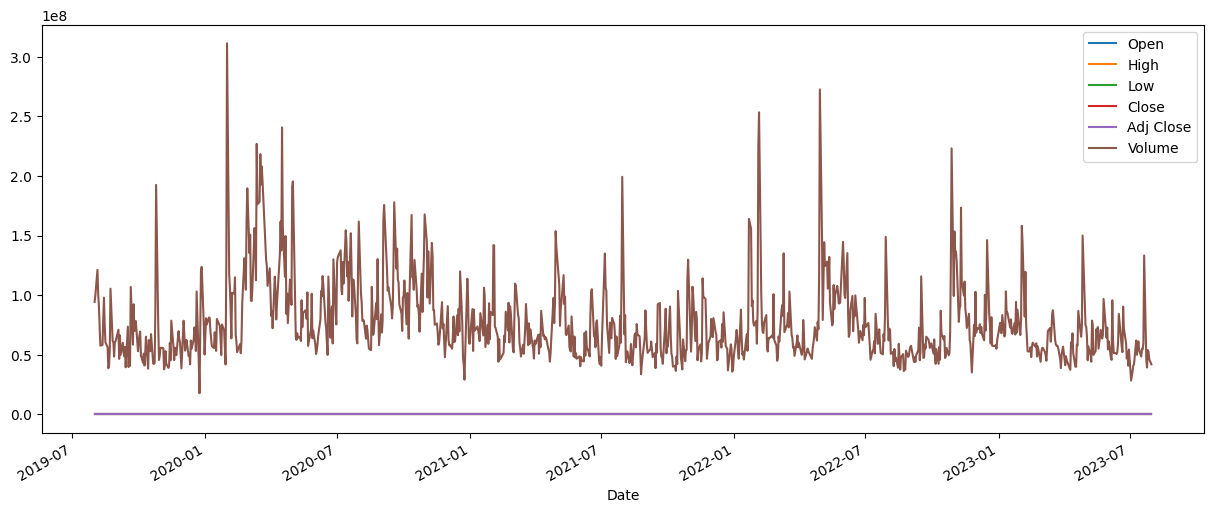

In [7]:
#Visualization of the dataset over the last 4 years
plt.figure(figsize=(15, 6))
df.plot(ax=plt.gca())
plt.show()

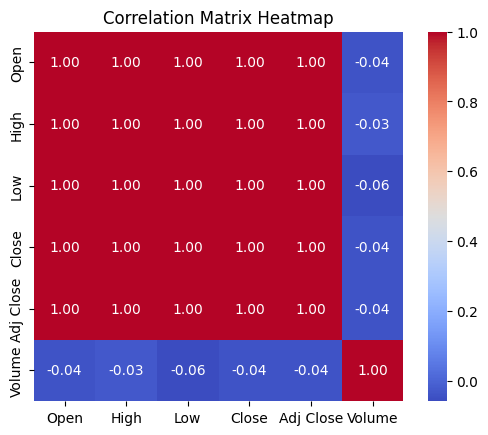

In [8]:
#Generating heatmap to see the dependency between the variables
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

<Axes: xlabel='Date'>

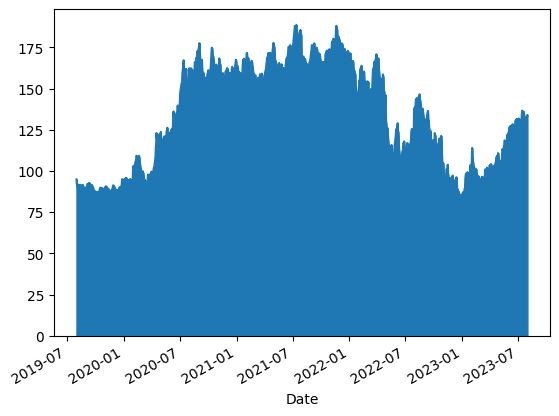

In [13]:
#To visualize the High column over the last 4 years
df["High"].plot.area()

In [14]:
#The dataset with only the "High" parameter
df_high=pd.DataFrame(df["High"])
df_high.head()

,High
Date,
2019-08-01,94.896004
2019-08-02,92.318001
2019-08-05,89.433502
2019-08-06,89.688499
2019-08-07,89.946503


In [15]:
#Downloaded the historical ESG scores data for Amazon from Yahoo Finance over the last 4 years!!!

dataframes = []
url = "https://query2.finance.yahoo.com/v1/finance/esgChart?symbol=AMZN"

connection = urllib.request.urlopen(url)

ESGdata = json.loads(connection.read())
ESGdf = pd.DataFrame(ESGdata["esgChart"]["result"][0]["symbolSeries"])
ESGdf["timestamp"] = pd.to_datetime(ESGdf["timestamp"], unit="s")
# Convert to daily frequency
ESGdf.set_index("timestamp", inplace=True)

# Print the resulting DataFrame
ESGdf

,esgScore,governanceScore,environmentScore,socialScore
timestamp,,,,
2014-09-01,51.00,50.00,44.00,56.0
2014-10-01,51.00,50.00,44.00,56.0
2014-11-01,51.00,50.00,44.00,56.0
2014-12-01,50.00,50.00,46.00,55.0
2015-01-01,50.00,50.00,46.00,55.0
...,...,...,...,...
2022-04-01,NaN,NaN,NaN,NaN
2022-05-01,30.23,9.84,5.59,14.8
2022-06-01,NaN,NaN,NaN,NaN


In [16]:
# Create a copy of the df_high DataFrame
df_high_with_esg = df_high.copy()

# Resample the ESGdf to have daily frequency, forward fill missing values
ESGdf_daily = ESGdf.resample("D").ffill()

# Merge df_high_with_esg and ESGdf_daily based on index (date)
merged_df = df_high_with_esg.merge(ESGdf_daily["esgScore"], left_index=True, right_index=True, how="left")

# Print the resulting merged DataFrame with the added ESG_Score column
merged_df

,High,esgScore
Date,,
2019-08-01,94.896004,44.83
2019-08-02,92.318001,44.83
2019-08-05,89.433502,44.83
2019-08-06,89.688499,44.83
2019-08-07,89.946503,44.83
...,...,...
2023-07-25,129.580002,NaN
2023-07-26,129.080002,NaN
2023-07-27,132.630005,NaN


In [17]:
# Calculate the mean of the non-missing values in the esgScore column
esg_mean = merged_df["esgScore"].mean()

# Round the mean value to two decimal places
esg_mean_rounded = round(esg_mean, 2)

# Impute missing values with the rounded mean
merged_df["esgScore"].fillna(esg_mean_rounded, inplace=True)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2019-08-01 to 2023-07-31
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   High      1006 non-null   float64
 1   esgScore  1006 non-null   float64
dtypes: float64(2)
memory usage: 55.9 KB


In [21]:
#The merged dataset with the "High" parameter
merged_df

,High,esgScore
Date,,
2019-08-01,94.896004,44.83
2019-08-02,92.318001,44.83
2019-08-05,89.433502,44.83
2019-08-06,89.688499,44.83
2019-08-07,89.946503,44.83
...,...,...
2023-07-25,129.580002,33.14
2023-07-26,129.080002,33.14
2023-07-27,132.630005,33.14


In [22]:
#Checking for null values
merged_df.isnull().sum()

High        0
esgScore    0
dtype: int64

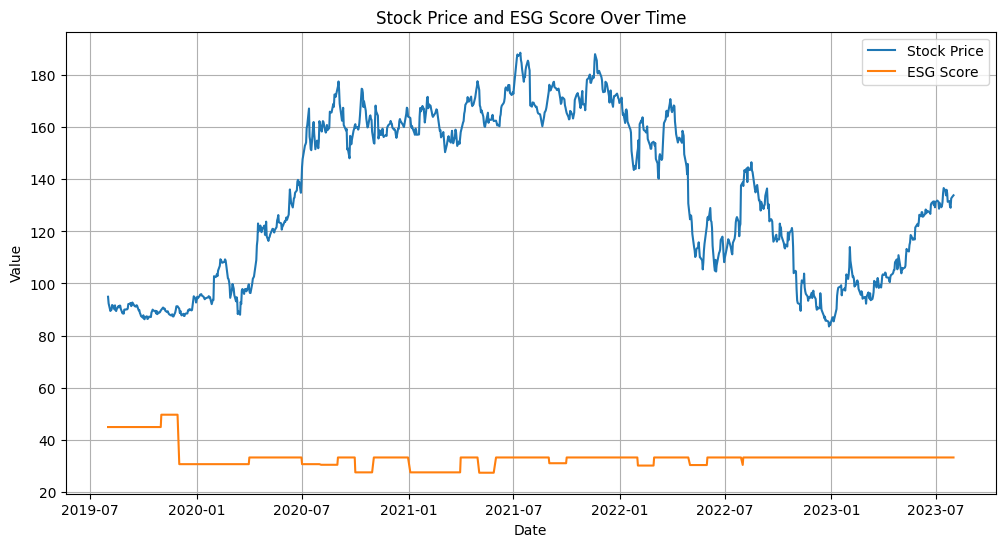

In [23]:
plt.figure(figsize=(12, 6))

# Plot High column (stock price)
plt.plot(merged_df.index, merged_df["High"], label="Stock Price")

# Plot esgScore column (ESG scores)
plt.plot(merged_df.index, merged_df["esgScore"], label="ESG Score")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Stock Price and ESG Score Over Time")
plt.legend()
plt.grid()

plt.show()


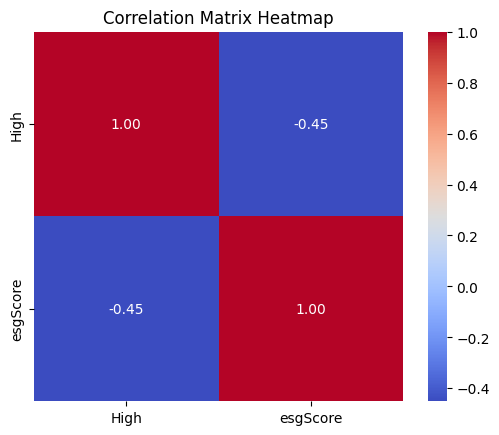

In [25]:
#Generating heatmap to see the dependency between the variables
sns.heatmap(merged_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

#Rolling Windows

In [28]:
#I will make the dataset longer, by adding new columns for identification and sorting, which i will be using in the next function
df_melted = pd.DataFrame(merged_df.copy())
df_melted["date"] = df_melted.index
df_melted["Symbols"] = "AMZN"
df_melted.head()

,High,esgScore,date,Symbols
Date,,,,
2019-08-01,94.896004,44.83,2019-08-01,AMZN
2019-08-02,92.318001,44.83,2019-08-02,AMZN
2019-08-05,89.433502,44.83,2019-08-05,AMZN
2019-08-06,89.688499,44.83,2019-08-06,AMZN
2019-08-07,89.946503,44.83,2019-08-07,AMZN


In [32]:
#Using tsfresh feature for creating rolling windows
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date", max_timeshift=20, min_timeshift=5)
df_rolled.head()

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 1006/1006 [00:02<00:00, 367.58it/s]


,High,esgScore,date,Symbols,id
0,94.896004,44.83,2019-08-01,AMZN,"(AMZN, 2019-08-08 00:00:00)"
1,92.318001,44.83,2019-08-02,AMZN,"(AMZN, 2019-08-08 00:00:00)"
2,89.433502,44.83,2019-08-05,AMZN,"(AMZN, 2019-08-08 00:00:00)"
3,89.688499,44.83,2019-08-06,AMZN,"(AMZN, 2019-08-08 00:00:00)"
4,89.946503,44.83,2019-08-07,AMZN,"(AMZN, 2019-08-08 00:00:00)"


In [31]:
#We "lost" 5 windows, as we required to have a minimum history of more than 5 days.
print(len(df_melted))
df_rolled["id"].nunique()

1006


1001

#Extract features

In [34]:
# Feature extraction for "High" column
extracted_df = extract_features(df_rolled.drop(["Symbols"], axis=1),
                          column_id="id", column_sort="date", column_value="High",
                          impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 1001/1001 [01:30<00:00, 11.11it/s]


In [35]:
extracted_df.head()

High__variance_larger_than_standard_deviation  \
AMZN 2019-08-08                                            1.0   
     2019-08-09                                            1.0   
     2019-08-12                                            1.0   
     2019-08-13                                            1.0   
     2019-08-14                                            1.0   

                 High__has_duplicate_max  High__has_duplicate_min  \
AMZN 2019-08-08                      0.0                      0.0   
     2019-08-09                      0.0                      0.0   
     2019-08-12                      0.0                      0.0   
     2019-08-13                      0.0                      0.0   
     2019-08-14                      0.0                      0.0   

                 High__has_duplicate  High__sum_values  High__abs_energy  \
AMZN 2019-08-08                  0.0        547.995506      50071.890286   
     2019-08-09                  0.0        639.550003      58454.116164   
     2019-08-12                  0.0        729.599007      66562.939214   
     2019-08-13                  0.0        821.186005      74951.117414   
     2019-08-14                  0.0        910.968506      83012.014939   

                 High__mean_abs_change  High__mean_change  \
AMZN 2019-08-08               1.548399          -0.636601   
     2019-08-09               1.316750          -0.556918   
     2019-08-12               1.343713          -0.692429   
     2019-08-13               1.367998          -0.413626   
     2019-08-14               1.416498          -0.568167   

                 High__mean_second_derivative_central  High__median  ...  \
AMZN 2019-08-08                              0.543062     90.829750  ...   
     2019-08-09                              0.241950     91.554497  ...   
     2019-08-12                              0.089376     90.801750  ...   
     2019-08-13                              0.294000     91.554497  ...   
     2019-08-14                              0.048344     90.801750  ...   

                 High__fourier_entropy__bins_5  \
AMZN 2019-08-08                       1.039721   
     2019-08-09                       1.039721   
     2019-08-12                       1.054920   
     2019-08-13                       1.332179   
     2019-08-14                       1.242453   

                 High__fourier_entropy__bins_10  \
AMZN 2019-08-08                        1.039721   
     2019-08-09                        1.386294   
     2019-08-12                        1.332179   
     2019-08-13                        1.332179   
     2019-08-14                        1.560710   

                 High__fourier_entropy__bins_100  \
AMZN 2019-08-08                         1.386294   
     2019-08-09                         1.386294   
     2019-08-12                         1.609438   
     2019-08-13                         1.609438   
     2019-08-14                         1.791759   

                 High__permutation_entropy__dimension_3__tau_1  \
AMZN 2019-08-08                                       1.039721   
     2019-08-09                                       1.332179   
     2019-08-12                                       1.329661   
     2019-08-13                                       1.549826   
     2019-08-14                                       1.732868   

                 High__permutation_entropy__dimension_4__tau_1  \
AMZN 2019-08-08                                       1.098612   
     2019-08-09                                       1.386294   
     2019-08-12                                       1.609438   
     2019-08-13                                       1.791759   
     2019-08-14                                       1.945910   

                 High__permutation_entropy__dimension_5__tau_1  \
AMZN 2019-08-08                                       0.693147   
     2019-08-09                                       1.098612   
     2019-0

In [36]:
#For better representation, I set the index to be the the last date
extracted_df = extracted_df.set_index(extracted_df.index.map(lambda x: x[1]), drop=True)
extracted_df.index.name = "last_date"
extracted_df.head()

,High__variance_larger_than_standard_deviation,High__has_duplicate_max,High__has_duplicate_min,High__has_duplicate,High__sum_values,High__abs_energy,High__mean_abs_change,High__mean_change,High__mean_second_derivative_central,High__median,...,High__fourier_entropy__bins_5,High__fourier_entropy__bins_10,High__fourier_entropy__bins_100,High__permutation_entropy__dimension_3__tau_1,High__permutation_entropy__dimension_4__tau_1,High__permutation_entropy__dimension_5__tau_1,High__permutation_entropy__dimension_6__tau_1,High__permutation_entropy__dimension_7__tau_1,High__query_similarity_count__query_None__threshold_0.0,High__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2019-08-08,1.0,0.0,0.0,0.0,547.995506,50071.890286,1.548399,-0.636601,0.543062,90.829750,...,1.039721,1.039721,1.386294,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,140.938570
2019-08-09,1.0,0.0,0.0,0.0,639.550003,58454.116164,1.316750,-0.556918,0.241950,91.554497,...,1.039721,1.386294,1.386294,1.332179,1.386294,1.098612,0.693147,-0.000000,0.0,140.938570
2019-08-12,1.0,0.0,0.0,0.0,729.599007,66562.939214,1.343713,-0.692429,0.089376,90.801750,...,1.054920,1.332179,1.609438,1.329661,1.609438,1.386294,1.098612,0.693147,0.0,91.452215
2019-08-13,1.0,0.0,0.0,0.0,821.186005,74951.117414,1.367998,-0.413626,0.294000,91.554497,...,1.332179,1.332179,1.609438,1.549826,1.791759,1.609438,1.386294,1.098612,0.0,91.723429
2019-08-14,1.0,0.0,0.0,0.0,910.968506,83012.014939,1.416498,-0.568167,0.048344,90.801750,...,1.242453,1.560710,1.791759,1.732868,1.945910,1.791759,1.609438,1.386294,0.0,91.723429


#Prediction

##Data split

In [39]:
#Remove last row-target
y = df_melted.set_index("date").sort_index().High.shift(-1)
y

date
2019-08-01     92.318001
2019-08-02     89.433502
2019-08-05     89.688499
2019-08-06     89.946503
2019-08-07     91.712997
                 ...    
2023-07-25    129.080002
2023-07-26    132.630005
2023-07-27    133.009995
2023-07-28    133.869995
2023-07-31           NaN
Name: High, Length: 1006, dtype: float64

In [40]:
#Compare
y["2019-08-08"], df.High["2019-08-09"]

(91.55449676513672, 91.55449676513672)

In [41]:
#Copy df
X = pd.DataFrame(extracted_df.copy())

In [42]:
#Check consistency
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

In [43]:
X = X.loc[X.index !=  "2023-07-31" ]
y = y.loc[y.index !=  "2023-07-31" ]

In [44]:
# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 783)
X_test shape: (200, 783)
y_train shape: (800,)
y_test shape: (200,)


In [45]:
#Take most valuable features
X_train_selected = select_features(X_train, y_train)
X_train_selected.head()

,"High__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)","High__cwt_coefficients__coeff_13__w_10__widths_(2, 5, 10, 20)","High__cwt_coefficients__coeff_14__w_20__widths_(2, 5, 10, 20)",High__minimum,"High__cwt_coefficients__coeff_14__w_5__widths_(2, 5, 10, 20)","High__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)",High__mean,High__quantile__q_0.1,High__root_mean_square,"High__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)",...,"High__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""","High__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","High__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",High__partial_autocorrelation__lag_8,"High__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6","High__fft_coefficient__attr_""angle""__coeff_2",High__partial_autocorrelation__lag_1,High__autocorrelation__lag_1,"High__fft_coefficient__attr_""angle""__coeff_1",High__approximate_entropy__m_2__r_0.7
last_date,,,,,,,,,,,,,,,,,,,,,
2019-09-19,284.221328,293.865469,270.782281,88.392998,142.880032,284.941734,90.913904,88.970001,90.922189,299.929218,...,0.887908,0.020808,1.849046,0.866172,0.000000,1.252545,0.789562,0.789562,103.686272,0.622983
2021-09-22,541.614320,561.391371,517.597665,165.774506,268.992178,544.780639,172.714357,166.600006,172.754479,574.296172,...,0.120762,1.991396,-2.976706,-0.536200,0.019812,143.107388,0.825936,0.825936,173.723012,0.352244
2022-05-11,403.056376,424.995718,396.415817,110.155998,177.161599,422.179693,138.553619,114.000000,139.539042,442.858103,...,-0.973347,8.163595,-0.576432,-0.645622,0.589832,-84.864794,0.910826,0.910826,-93.124301,0.192246
2021-10-22,521.081380,537.922490,497.476589,163.036499,259.016758,523.969011,167.768906,163.376495,167.804777,548.455417,...,0.711467,1.759602,3.254600,-0.243977,0.667903,87.886187,0.874230,0.874230,35.477130,0.379858
2022-12-01,299.704243,310.618440,286.486845,89.480003,145.368855,301.404801,95.913334,92.099998,95.971345,317.714020,...,0.868220,0.476103,3.417306,-0.450684,0.172223,61.369815,0.635372,0.635372,-171.175795,0.305657


In [46]:
#train with LinearRegression
LinearModel = LinearRegression()
LinearModel.fit(X_train_selected, y_train)

X_test_selected = X_test[X_train_selected.columns]

y_pred_Linear = pd.Series(LinearModel.predict(X_test_selected), index=X_test_selected.index)

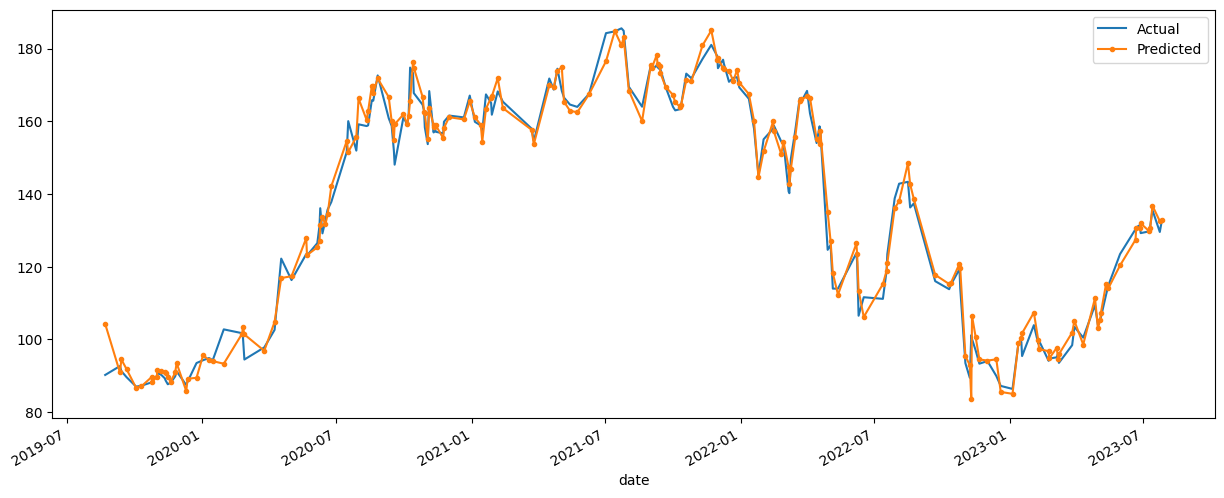

In [47]:
# Visualize predicted vs. actual values
plt.figure(figsize=(15, 6))
y_test.plot(ax=plt.gca(), label="Actual")
pd.Series(y_pred_Linear, index=y_test.index).plot(ax=plt.gca(), label="Predicted", marker=".")
plt.legend()
plt.show()

In [48]:
#Evaluate LinearRegression model
mseLinear = mean_squared_error(y_test, y_pred_Linear)
rmseLinear = np.sqrt(mseLinear)

print("Root Mean Squared Error:", rmseLinear)

r2Linear = r2_score(y_test, y_pred_Linear)
print("R-squared:", r2Linear)

Root Mean Squared Error: 3.5470238310234814
R-squared: 0.9871709850673164


In [49]:
# Model training RandomForest
ForestModel = RandomForestRegressor(n_estimators=100, random_state=42)
ForestModel.fit(X_train, y_train)
y_pred_Forest = ForestModel.predict(X_test)

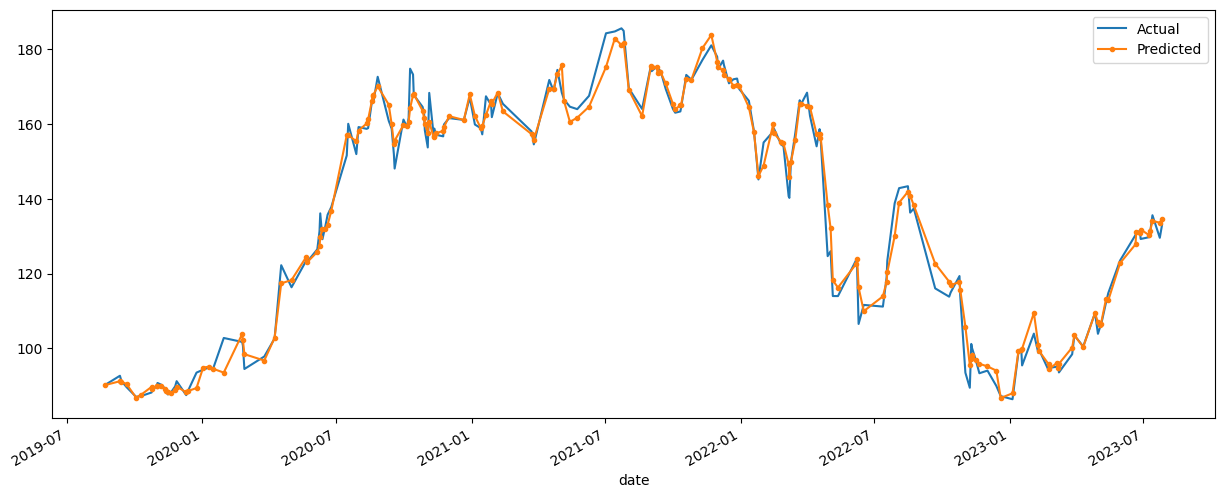

In [50]:
# Visualize predicted vs. actual values
plt.figure(figsize=(15, 6))
y_test.plot(ax=plt.gca(), label="Actual")
y_pred_Forest_series = pd.Series(y_pred_Forest, index=y_test.index).plot(ax=plt.gca(), label="Predicted", marker=".")
plt.legend()
plt.show()

In [51]:
# Model evaluation
mseForest = mean_squared_error(y_test, y_pred_Forest)
rmseForest = np.sqrt(mseForest)
print("Root Mean Squared Error:", rmseForest)

Root Mean Squared Error: 3.203328047094431


In [52]:
#Model evaluation
r2Forest = r2_score(y_test, y_pred_Forest)
print("R-squared:", r2Forest)

R-squared: 0.9895367179954513


In [53]:
# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_selected)

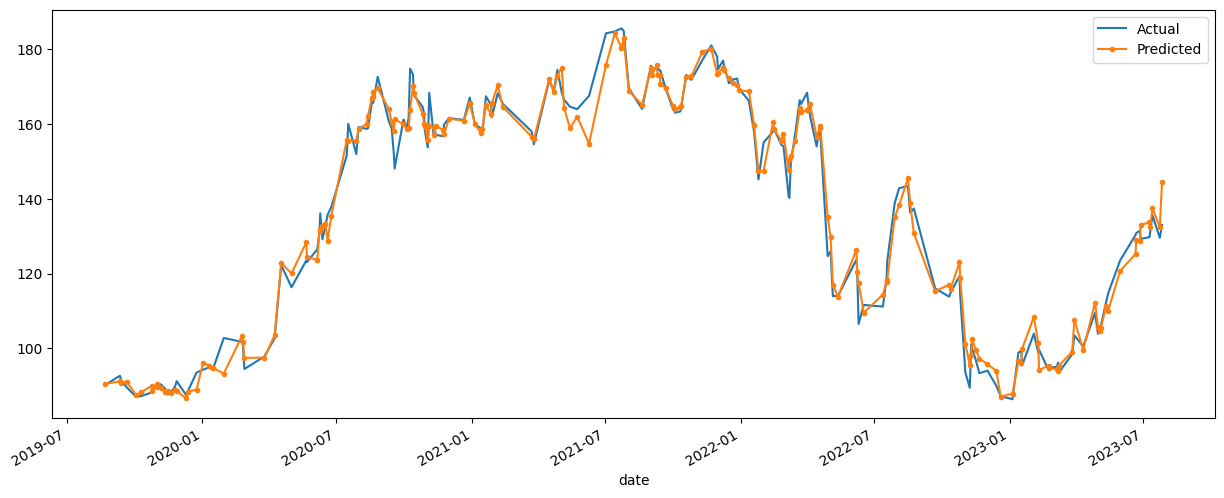

In [54]:
# Visualize predicted vs. actual values
plt.figure(figsize=(15, 6))
y_test.plot(ax=plt.gca(), label="Actual")
y_pred_xgb_series = pd.Series(y_pred_xgb, index=y_test.index).plot(ax=plt.gca(), label="Predicted", marker=".")
plt.legend()
plt.show()

In [55]:
# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Root Mean Squared Error:", rmse_xgb)
print("XGBoost R-squared:", r2_xgb)

XGBoost Root Mean Squared Error: 3.5967135063453513
XGBoost R-squared: 0.9868090282715632


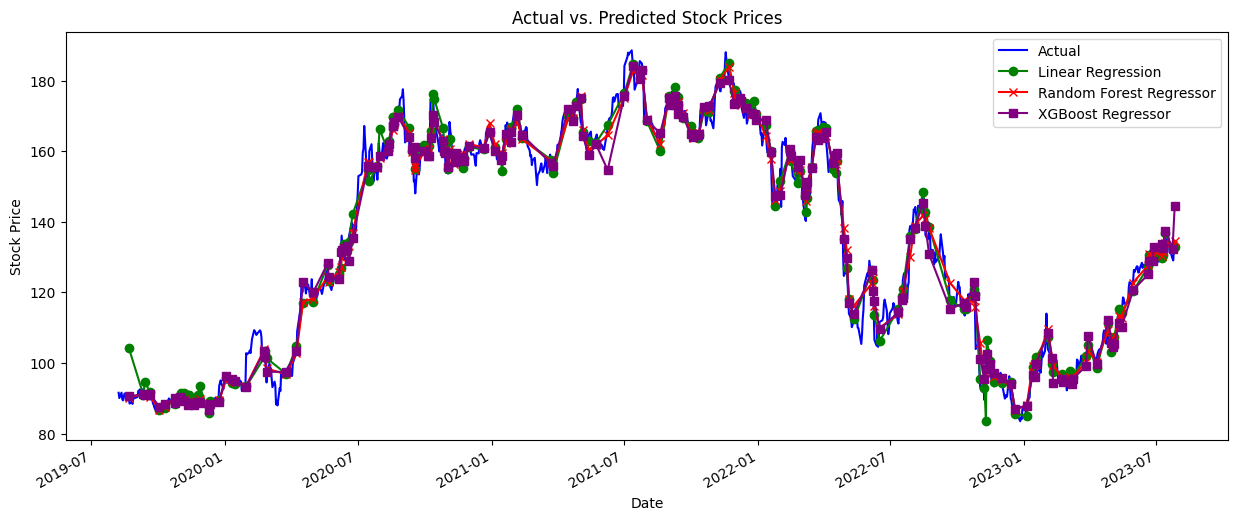

In [56]:
# Convert NumPy arrays to Pandas Series
y_pred_Linear_series = pd.Series(y_pred_Linear, index=X_test_selected.index)
y_pred_Forest_series = pd.Series(y_pred_Forest, index=X_test_selected.index)
y_pred_xgb_series = pd.Series(y_pred_xgb, index=X_test_selected.index)

# Plot the actual values and predictions
plt.figure(figsize=(15, 6))
y.plot(ax=plt.gca(), label="Actual", color='blue')
y_pred_Linear_series.plot(ax=plt.gca(), label="Linear Regression", color='green', marker='o')
y_pred_Forest_series.plot(ax=plt.gca(), label="Random Forest Regressor", color='red', marker='x')
y_pred_xgb_series.plot(ax=plt.gca(), label="XGBoost Regressor", color='purple', marker='s')

plt.legend()
plt.title("Actual vs. Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

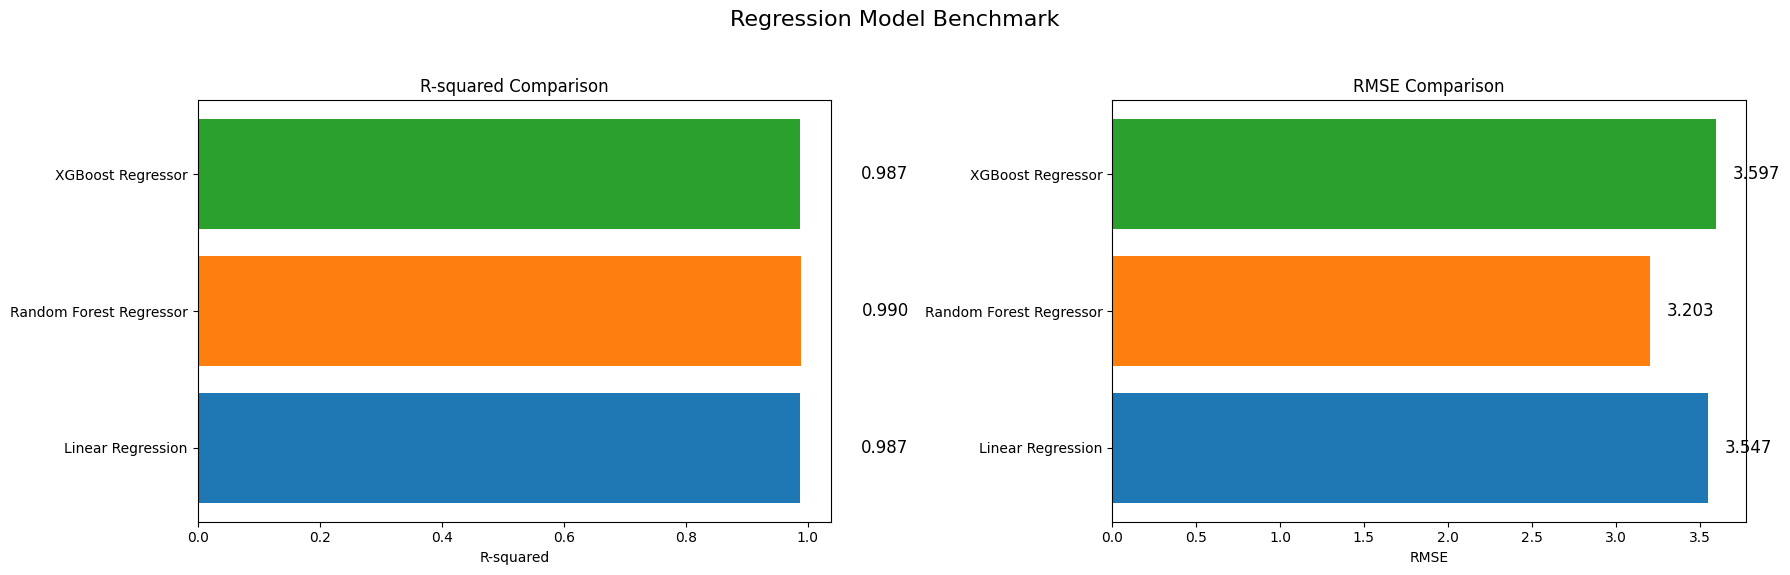

The best model based on RMSE is Random Forest Regressor.


In [59]:
# Define the metrics for each model
models = {
    'Linear Regression': {'R-squared': r2Linear, 'RMSE': rmseLinear},
    'Random Forest Regressor': {'R-squared': r2Forest, 'RMSE': rmseForest},
    'XGBoost Regressor': {'R-squared': r2_xgb, 'RMSE': rmse_xgb}
}

# Extract metric names and values
metric_names = ['R-squared', 'RMSE']
model_names = list(models.keys())
metrics = {metric: [model_data[metric] for model_data in models.values()] for metric in metric_names}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(metric_names), figsize=(18, 6))

# Create a color map for models
colors = plt.cm.tab10(np.arange(len(model_names)))

# Plot each metric on a separate subplot
for i, metric in enumerate(metric_names):
    ax = axes[i]
    ax.barh(model_names, metrics[metric], color=colors)
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} Comparison')

    # Add annotations to the bars
    for j, value in enumerate(metrics[metric]):
        ax.text(value + 0.1, j, f'{value:.3f}', va='center', fontsize=12)

# Add a title to the entire figure
fig.suptitle('Regression Model Benchmark', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

# Conclusion
best_model = model_names[np.argmin(metrics['RMSE'])]
print(f"The best model based on RMSE is {best_model}.")
